In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("sap_storing_data_hu_project.csv", low_memory=False)

In [3]:
pd.set_option("display.max_columns", None)

In [4]:
df.head()

,Unnamed: 0,#stm_sap_meldnr,stm_mon_nr,stm_vl_post,stm_sap_meld_ddt,stm_sap_mon_meld_ddt,stm_sap_meldtekst_lang,stm_mon_begin_ddt,stm_sap_meldtekst,stm_mon_toelichting_trdl,stm_oh_pg_mld,stm_geo_mld,stm_geo_mld_uit_functiepl,stm_equipm_nr_mld,stm_equipm_soort_mld,stm_equipm_omschr_mld,stm_km_van_mld,stm_km_tot_mld,stm_prioriteit,stm_scenario_mon,stm_status_melding_sap,stm_mon_nr_status_omschr,stm_mon_nr__statuscode,stm_mon_nr_status_wijzdd,stm_aanngeb_ddt,stm_aanntpl_ddt,stm_oh_pg_gst,stm_geo_gst,stm_geo_gst_uit_functiepl,stm_equipm_nr_gst,stm_equipm_soort_gst,stm_equipm_omschr_gst,stm_objectdl_code_gst,stm_objectdl_groep_gst,stm_km_van_gst,stm_km_tot_gst,stm_progfh_in_ddt,stm_progfh_in_invoer_ddt,stm_progfh_gw_ddt,stm_progfh_gw_lwd_ddt,stm_progfh_hz,stm_oorz_groep,stm_oorz_code,stm_oorz_tkst,stm_veroorz_groep,stm_veroorz_code,stm_veroorz_tekst_kort,stm_effect,stm_afspr_aanvangddt,stm_fh_ddt,stm_fh_status,stm_sap_storeind_ddt,stm_mon_eind_ddt,stm_mon_vhdsincident,stm_tao_indicator,stm_tao_indicator_vorige,stm_tao_soort_mutatie,stm_tao_telling_mutatie,stm_tao_beinvloedbaar_indicator,stm_evb,stm_dir_betrok_tr,stm_aangelegd_dd,stm_aangelegd_tijd,stm_sap_melddatum,stm_sap_meldtijd,stm_mon_begindatum,stm_mon_begintijd,stm_contractgeb_mld,stm_functiepl_mld,stm_techn_mld,stm_contractgeb_gst,stm_functiepl_gst,stm_techn_gst,stm_aanngeb_dd,stm_aanngeb_tijd,stm_aanntpl_dd,stm_aanntpl_tijd,stm_arbeid,stm_progfh_in_datum,stm_progfh_in_tijd,stm_progfh_in_invoer_dat,stm_progfh_in_invoer_tijd,stm_progfh_in_duur,stm_progfh_gw_datum,stm_progfh_gw_tijd,stm_progfh_gw_lwd_datum,stm_progfh_gw_lwd_tijd,stm_progfh_gw_duur,stm_progfh_gw_teller,stm_afspr_aanvangdd,stm_afspr_aanvangtijd,stm_fh_dd,stm_fh_tijd,stm_fh_duur,stm_reactie_duur,stm_sap_storeinddatum,stm_sap_storeindtijd,stm_mon_eind_datum,stm_mon_eind_tijd,stm_controle_dd,stm_akkoord_mon_toewijz,stm_status_sapnaarmon,stm_fact_jn,stm_akkoord_melding_jn,stm_afsluit_ddt,stm_afsluit_dd,stm_afsluit_tijd,stm_rec_toegev_ddt,stm_hinderwaarde,stm_actie,stm_standplaats,stm_status_gebr,stm_wbi_nummer,stm_projnr,stm_oorz_tekst_kort,stm_historie_toelichting,stm_schade_verhaalb_jn,stm_schadenr,stm_schade_status_ga,stm_schade_statusdatum,stm_relatiervo_vorig,stm_relatiervo_volgend,stm_relatiervo,stm_pplg_van,stm_pplg_naar,stm_dstrglp_van,stm_dstrglp_naar,stm_afspr_func_hersteldd,stm_afspr_func_hersteltijd,stm_sorteerveld,stm_rapportage_maand,stm_rapportage_jaar,stm_x_bron_publ_dt,stm_x_bron_bestandsnaam,stm_x_bron_arch_dt,stm_x_actueel_ind,stm_x_run_id,stm_x_bk,stm_x_start_sessie_dt,stm_x_vervallen_ind
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,0,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2014,07/05/2014 05:30:12,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1,34415,3617016,07/05/2014 05:44:24,0
1,1,50053211,0.0,NaN,02/01/2006 09:00:00,02/01/2006 09:00:00,Logboeknr Geeltje : 49 Tijd: 0900 VL-Po...,NaN,Logboeknr Geeltje : 49 Tijd: 0900,NaN,NaN,624.0,624.0,NaN,NaN,NaN,0.0,0.0,9.0,NaN,MAFS MAFD,NaN,NaN,00/00/0000,02/01/2006 09:00:00,NaN,81S,624.0,624.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,Z,ONR-RIB,133.0,Papieren ontbreken,ONREGRIB,B,Volker,NaN,NaN,02/01/2006 09:00:00,4.0,02/01/2006 09:00:00,NaN,NaN,N,NaN,NaN,0,B,"0,00",NaN,03/01/2006,04:48:18,02/01/2006,09:00:00,NaN,NaN,NaN,624,NaN,81.0,624,S,02/01/2006,09:00:00,NaN,00:00:00,99999999.0,NaN,00:00:00,NaN,00:00:00,99999999.0,NaN,00:00:00,NaN,NaN,99999999.0,0.0,00/00/0000,00:00:00,02/01/2006,09:00:00,0.0,99999999.0,02/01/2006,09:00:00,NaN,NaN,05/01/2006,J,NaN,N,J,05/01/2009 15:10:09,05/01/2009,15:10:09,02/01/2006 04:

In [5]:
#De eerste kolom is leeg, dus deze halen we er alvast uit.
df = df.drop([0,0])

In [6]:
# Meest efficiente manier om het aantal rijen te achterhalen
print("Aantal rijen in de dataset:", len(df.index))

Aantal rijen in de dataset: 898525


### Baseline Model
Het is belangrijk om een baseline te hebben. Dit is een rudimentaire voorspelling, die we als lat leggen om te verbeteren met onze andere modellen. Wat willen we eigenlijk voorspellen?

### Doel oftewel 'Target'
Ons doel is om te voorspellen wanneer het systeem weer opgestart kan worden. De manier waarop je dit meet, is door te kijken hoe lang de functie hersteltijd heeft geduurd. Hiervoor hebben we de volgende belangrijke datapunten geïdentificeerd:
- Datum en tijdstip van functie herstel
- Duur van functie herstel
- Datum en tijdstip van einde storing

Vooral de duur van de functieherstel is belangrijk, dus hier gaan we naar kijken. Deze staat in de database als "stm_fh_duur", maar gaan we hernoemen voor leesbaarheid.

In [7]:
# Hernoemt de functie herstel duur kolom.
df = df.rename(columns={'stm_fh_duur': 'functie_herstel_duur'})

In [8]:
df[['functie_herstel_duur']].head(10)

,functie_herstel_duur
1,0.0
2,51.0
3,40.0
4,6.0
5,7.0
6,13.0
7,15.0
8,30.0
9,0.0
10,0.0


Nu zien we de waarden die bij de target variabel horen. Deze data is waarschijnlijk uitgedrukt in minuten. Dit is een aanname die wij voorlopig doen, tot we dit verifiëren. Dit is een **continue** waarde, hoewel de minuten zijn afgerond.

In [9]:
df.functie_herstel_duur.describe()

count    898488.000000
mean        923.148771
std        6404.546787
min           0.000000
25%          11.000000
50%          84.000000
75%         256.000000
max      528297.000000
Name: functie_herstel_duur, dtype: float64

De bovenste gegevens laten het een en ander zien over de gegevens in de feature variabel. 
- We hebben 898488 datapunten, dus missen we er 37, ofwel 0.004%. Dit is vrijwel niets. We kunnen deze rijen dus uit de dataframe verwijderen zonder dat dit gevolgen zal hebben op de uitkomst.
- De gemiddelde hersteltijd is 923 minuten;
- De standaardafwijking ligt op 6404 minuten. Deze waarden kunnen nooit realistisch zijn, wat betekent dat we veel datapunten hebben die de waarden scheeftrekken.
- 25% van de waarden liggen op of onder 11 minuten;
- 50% van de waarden liggen op of onder 84 minuten;
- 75% van de waarden liggen op of onder 256 minuten;
- De maximum ligt op 528297 minuten.

Waarom deze waarden zo hoog liggen gaan we later onderzoeken. Ten eerste is het handig om te zien hoe de data verdeeld is in een boxplot.

<AxesSubplot:>

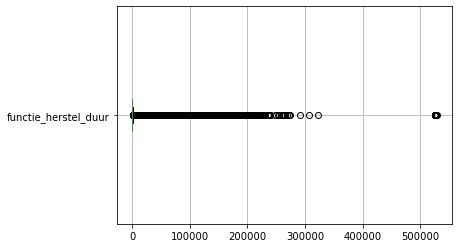

In [10]:
df.boxplot('functie_herstel_duur', vert=False)

Op de boxplot valt duidelijk te zien dat we met erg veel uitschieters te maken hebben aan de hoge kant. Deze gaan we later verwijderen omdat ze geen waarde toevoegen aan het maken van een nuttige voorspelling. Om dit te doen, moeten we gebruik maken van de kwartielen en interkwartielafstand.
We hebben we ook uitschieters aan de onderkant. Echter zijn deze wel van belang. Een storing van 1 minuut is nog steeds een storing waarover we voorspellingen willen doen. Daarom halen we alleen de hoge outliers eruit. Daarnaast heeft de opdrachtgever aangegeven dat vooral de kortere storingen belangrijk zijn om te voorspellen.

In [11]:
q1 = df.functie_herstel_duur.quantile(.25)
q3 = df.functie_herstel_duur.quantile(.75)
iqr = q3 - q1

out_hi_st = df.functie_herstel_duur[(df.functie_herstel_duur >= q3 + iqr * 3)]
out_hi_wk = df.functie_herstel_duur[((df.functie_herstel_duur >= q3 + iqr * 1.5) & (df.functie_herstel_duur < q3 + iqr * 3))]
print("Er zitten {} ({:.2f}%) outliers aan de hoge kant, waarvan {} zwak en {} sterk.".format(out_hi_st.shape[0] + out_hi_wk.shape[0],
                                                                                          (out_hi_st.shape[0] + out_hi_wk.shape[0])/898525*100,
                                                                                          out_hi_wk.shape[0],
                                                                                          out_hi_st.shape[0]))
df = df[(df.functie_herstel_duur < (q3 + 1.5 * iqr))]

Er zitten 144190 (16.05%) outliers aan de hoge kant, waarvan 40357 zwak en 103833 sterk.


In [12]:
print("Er zijn {} nul-waarden, oftewel {}% van de originele dataset.".format(df[(df.functie_herstel_duur <= 0)].shape[0], df[(df.functie_herstel_duur <= 0)].shape[0] / 898525 * 100))
df = df[(df.functie_herstel_duur > 0)]

Er zijn 171713 nul-waarden, oftewel 19.110542277621658% van de originele dataset.


Een storing van 0 minuten halen we ook weg. We maken hierbij de **aanname** dat een storing van 0 minuten geen impact heeft op de reistijd. Zo een storing hoeft niet opgelost te worden en de trein kan meteen opstarten.

<AxesSubplot:>

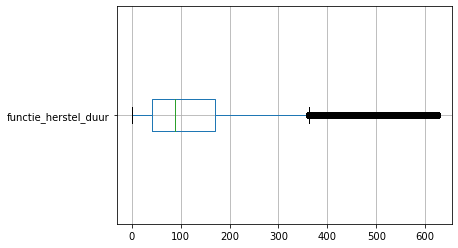

In [13]:
df.boxplot('functie_herstel_duur', vert=False)